In [1]:
#1. Import packages
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers,optimizers,losses,callbacks,applications,models
import numpy as np
import matplotlib.pyplot as plt
import os,datetime

In [2]:
!wget https://prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com/5y9wdsg2zt-2.zip

--2023-09-15 11:21:15--  https://prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com/5y9wdsg2zt-2.zip
Resolving prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com (prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com)... 52.218.61.208, 3.5.71.165, 52.218.100.184, ...
Connecting to prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com (prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com)|52.218.61.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 240847944 (230M) [application/octet-stream]
Saving to: ‘5y9wdsg2zt-2.zip’

5y9wdsg2zt-2.zip    100%[===================>] 229.69M  19.4MB/s    in 12s     

2023-09-15 11:21:28 (18.6 MB/s) - ‘5y9wdsg2zt-2.zip’ saved [240847944/240847944]



In [3]:
!unzip "5y9wdsg2zt-2.zip"

Archive:  5y9wdsg2zt-2.zip
  inflating: Concrete Crack Images for Classification.rar  


In [9]:
!unrar x "Concrete Crack Images for Classification.rar" "Positive"
!unrar x "Concrete Crack Images for Classification.rar" "Negative"

Streaming output truncated to the last 5000 lines.
Extracting  Negative/15002.jpg                                            88%  OK 
Extracting  Negative/15003.jpg                                            88%  OK 
Extracting  Negative/15004.jpg                                            88%  OK 
Extracting  Negative/15005.jpg                                            88%  OK 
Extracting  Negative/15006.jpg                                            88%  OK 
Extracting  Negative/15007.jpg                                            88%  OK 
Extracting  Negative/15008.jpg                                            88%  OK 
Extracting  Negative/15009.jpg                                            88%  OK 
Extracting  Negative/15010.jpg                                            88%  OK 
Extracting  Negative/15011.jpg                                            88%  OK 
Extracting  Negative/15012.jp

In [10]:
import shutil

# Create a dataset folder
os.makedirs("dataset", exist_ok=True)

# Move the "Positive" and "Negative" folders into the dataset folder
shutil.move("Positive", "dataset/Positive")
shutil.move("Negative", "dataset/Negative")

'dataset/Negative'

In [11]:
# Define batch size and image size for the dataset
BATCH_SIZE = 64
IMG_SIZE = (160, 160)
directory_path="/content/dataset"

# Create a dataset from the extracted folders
data = tf.keras.utils.image_dataset_from_directory(
    directory_path,
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
)

Found 40000 files belonging to 2 classes.


In [37]:
#3.0 Split dataset
train_size = int(len(data)*0.7)
val_size = int(len(data)*0.2) #to test model performance, during training phase
test_size = int(len(data)*0.1) #to test model performance, after training phase

In [38]:
train_dataset = data.take(train_size)
validation_dataset = data.skip(train_size).take(val_size)
test_dataset = data.skip(train_size+val_size).take(test_size)

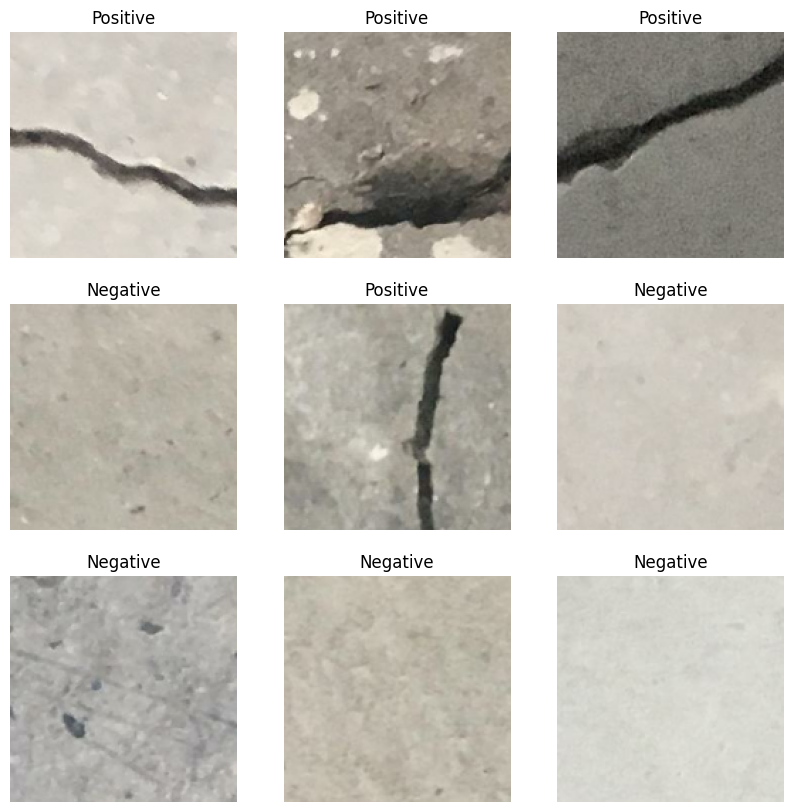

In [39]:
#4. Inspect some data examples
class_names = data.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [40]:
#5. Converting the tensorflow datasets into PrefetchDataset
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

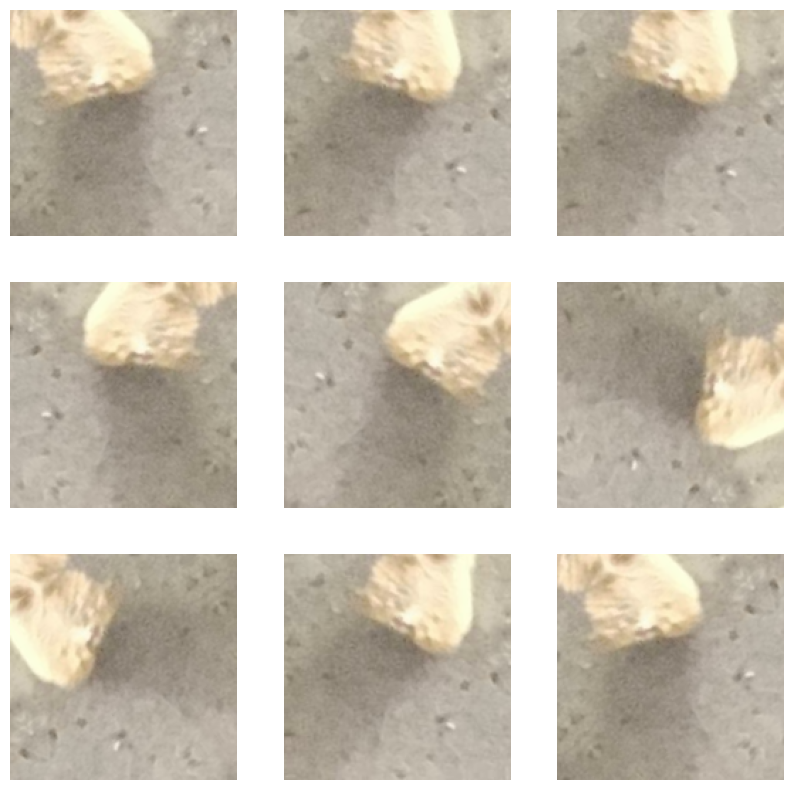

In [41]:
#6. Create a Sequential 'model' for data augmentation
data_augmentation = keras.Sequential()
data_augmentation.add(layers.RandomFlip('horizontal'))
data_augmentation.add(layers.RandomRotation(0.2))
# %%
#7. Repeatedly apply data augmentation on a single image
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 160, 160, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 80, 80, 32)           864       ['input_3[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 80, 80, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 80, 80, 32)           0         ['bn_Conv1[

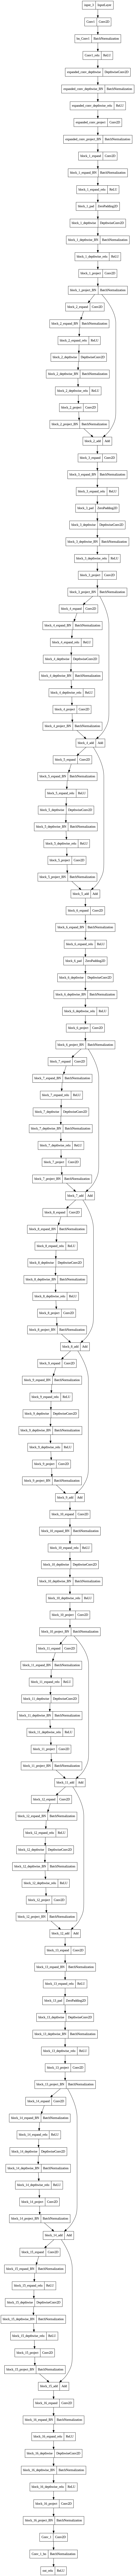

In [42]:
#8. Define a layer for data normalization/rescaling
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
# %%
"""
The plan:

data augmentation > preprocess input > transfer learning model
"""

IMG_SHAPE = IMG_SIZE + (3,)
#(A) Load the pretrained model using keras.applications module
base_model = applications.MobileNetV2(input_shape=IMG_SHAPE,include_top=False,weights='imagenet')
#Display summary of the model
base_model.summary()
#Display model structure
keras.utils.plot_model(base_model)

In [43]:
#(B) Freeze the entire feature extractor
base_model.trainable = False

In [44]:
#Display the model summary to show that most parameters are non-trainable
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 160, 160, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 80, 80, 32)           864       ['input_3[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 80, 80, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 80, 80, 32)           0         ['bn_Conv1[

In [45]:
#(C) Create global average pooling layer
global_avg = layers.GlobalAveragePooling2D()
#(D) Create the output layer
output_layer = layers.Dense(len(class_names),activation='softmax')
#(E) Build the entire pipeline using functional API
#a. Input
inputs = keras.Input(shape=IMG_SHAPE)
#b. Data augmentation model
x = data_augmentation(inputs)
#c. Data rescaling layer
x = preprocess_input(x)
#d. Transfer learning feature extractor
x = base_model(x,training=False)
#e. Final extracted features
x = global_avg(x)
#f. Classification layer
x = layers.Dropout(0.3)(x)
outputs = output_layer(x)
#g. Build the model
model = keras.Model(inputs=inputs,outputs=outputs)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv_1 (TFOpLam  (None, 160, 160, 3)       0         
 bda)                                                            
                                                                 
 tf.math.subtract_1 (TFOpLa  (None, 160, 160, 3)       0         
 mbda)                                                           
                                                                 
 mobilenetv2_1.00_160 (Func  (None, 5, 5, 1280)        2257984   
 tional)                                                         
                                                           

In [46]:
#10. Compile the model
optimizer = optimizers.Adam(learning_rate=0.0001)
loss = losses.SparseCategoricalCrossentropy()
model.compile(optimizer=optimizer,loss=loss,metrics=['accuracy'])

In [22]:
%load_ext tensorboard

In [63]:
#Create TensorBoard callback object
base_log_path = r"tensorboard_logs\transfer_learning_tutorial"
log_path = os.path.join(base_log_path,datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tb = callbacks.TensorBoard(log_path)

In [ ]:
%tensorboard --logdir tensorboard_logs\transfer_learning_tutorial

In [48]:
#11. Model training
#Evaluate the model before training
loss0,acc0 = model.evaluate(test_dataset)
print("Evaluation before training:")
print("Loss = ", loss0)
print("Accuracy = ",acc0)

62/62 [==============================] - 29s 59ms/step - loss: 0.8760 - accuracy: 0.5733
Evaluation before training:
Loss =  0.8759661912918091
Accuracy =  0.5733367204666138


In [49]:
#12. Proceed with model training
early_stopping = callbacks.EarlyStopping(patience=2)
EPOCHS = 10
history = model.fit(train_dataset,validation_data=validation_dataset,epochs=EPOCHS,callbacks=[tb,early_stopping])

Epoch 1/10
437/437 [==============================] - 55s 118ms/step - loss: 0.1634 - accuracy: 0.9390 - val_loss: 0.0243 - val_accuracy: 0.9965
Epoch 2/10
437/437 [==============================] - 48s 110ms/step - loss: 0.0259 - accuracy: 0.9940 - val_loss: 0.0131 - val_accuracy: 0.9970
Epoch 3/10
437/437 [==============================] - 50s 113ms/step - loss: 0.0167 - accuracy: 0.9961 - val_loss: 0.0104 - val_accuracy: 0.9975
Epoch 4/10
437/437 [==============================] - 67s 152ms/step - loss: 0.0146 - accuracy: 0.9953 - val_loss: 0.0093 - val_accuracy: 0.9977
Epoch 5/10
437/437 [==============================] - 50s 113ms/step - loss: 0.0115 - accuracy: 0.9965 - val_loss: 0.0083 - val_accuracy: 0.9975
Epoch 6/10
437/437 [==============================] - 47s 107ms/step - loss: 0.0105 - accuracy: 0.9969 - val_loss: 0.0067 - val_accuracy: 0.9980
Epoch 7/10
437/437 [==============================] - 48s 108ms/step - loss: 0.0096 - accuracy: 0.9968 - val_loss: 0.0067 - val_ac

In [50]:
#13. Further fine tune the model
# Let's take a look to see how many layers are in the base model
base_model.trainable = True
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  154


In [51]:
# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

In [52]:
#14. Compile the model
optimizer = optimizers.RMSprop(learning_rate=0.00001)
model.compile(optimizer=optimizer,loss=loss,metrics=['accuracy'])

In [53]:
#15. Model training
fine_tune_epoch = 10
total_epoch = EPOCHS + fine_tune_epoch
history_fine = model.fit(train_dataset,validation_data=validation_dataset,epochs=total_epoch,initial_epoch=history.epoch[-1],callbacks=[tb,early_stopping])

Epoch 10/20
437/437 [==============================] - 87s 129ms/step - loss: 0.0084 - accuracy: 0.9972 - val_loss: 0.0035 - val_accuracy: 0.9986
Epoch 11/20
437/437 [==============================] - 56s 127ms/step - loss: 0.0053 - accuracy: 0.9983 - val_loss: 0.0051 - val_accuracy: 0.9983
Epoch 12/20
437/437 [==============================] - 60s 136ms/step - loss: 0.0043 - accuracy: 0.9987 - val_loss: 0.0034 - val_accuracy: 0.9987
Epoch 13/20
437/437 [==============================] - 58s 132ms/step - loss: 0.0045 - accuracy: 0.9988 - val_loss: 0.0023 - val_accuracy: 0.9991
Epoch 14/20
437/437 [==============================] - 58s 132ms/step - loss: 0.0043 - accuracy: 0.9988 - val_loss: 0.0033 - val_accuracy: 0.9989
Epoch 15/20
437/437 [==============================] - 59s 134ms/step - loss: 0.0039 - accuracy: 0.9989 - val_loss: 0.0023 - val_accuracy: 0.9991
Epoch 16/20
437/437 [==============================] - 56s 129ms/step - loss: 0.0034 - accuracy: 0.9989 - val_loss: 0.0033 -

In [54]:
#Evaluate the model after training
loss1,acc1 = model.evaluate(test_dataset)
print("Evaluation After Training:")
print("Loss = ",loss1)
print("Accuracy = ",acc1)

62/62 [==============================] - 24s 57ms/step - loss: 0.0072 - accuracy: 0.9987
Evaluation After Training:
Loss =  0.007216595578938723
Accuracy =  0.9987398982048035


In [55]:
#16. Deployment
#(A) Retrieve a batch of images from the test set and perform predictions
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch)

In [56]:
prediction_index = np.argmax(predictions,axis=1)
#(B) Create a label map for the classes
label_map = {i:names for i,names in enumerate(class_names)}
prediction_label = [label_map[i] for i in prediction_index]
label_class_list = [label_map[i] for i in label_batch]

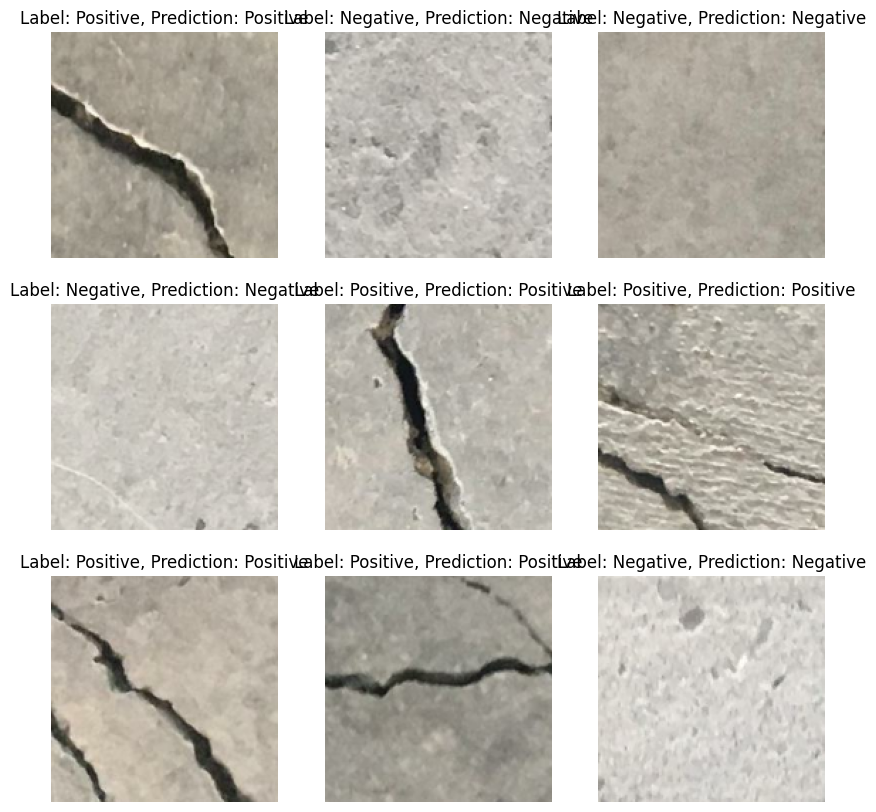

In [57]:
plt.figure(figsize=(10,10))
for i in range(9):
  ax = plt.subplot(3,3,i+1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(f"Label: {label_class_list[i]}, Prediction: {prediction_label[i]}")
  plt.axis('off')
  plt.grid('off')

In [58]:
#17.Save the model
model.save(os.path.join('models', 'assesment1_model.h5'))


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
